In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
import pandas as pd
import numpy as np
import pdb
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.lm_rnn import *
import datetime
import matplotlib.pyplot as plt

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
path = 'Solar/Data/'

In [169]:
pre_df = pd.read_csv(path + 'dataset_V3.csv')

In [170]:
# Remove pressure as NaN values make up 30% of data

In [171]:
pre_df = pre_df.drop(columns='pressure')

In [172]:
pre_df['date'] = pd.to_datetime(pre_df['date'])

In [173]:
add_datepart(pre_df, 'date', drop=False)

In [174]:
pre_df['Hour'] = pre_df.date.dt.hour

In [175]:
exempt = [904633, 770007, 778712, 852227, 771748, 805196, 844998]

In [176]:
for e in exempt:
    pre_df.drop(pre_df[pre_df['id'].values == e].index, inplace=True)
pre_df.reset_index(inplace=True)

In [177]:
cats = ['id', 'install_date', 'uvIndex', 'summary', 'precipType', 'export_limitation', 'Year' , 'Month', 'Week', 'Day', 
        'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 
        'Is_year_start', 'Hour']
conts = ['previous', 'temperature', 'windSpeed', 'apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 'windBearing', 'Elapsed']
dep = 'production'
n = len(pre_df); n

176424

In [178]:
for cat in cats:
    pre_df[cat] = pre_df[cat].astype('category').cat.as_ordered()

In [179]:
for cont in conts:
    pre_df[cont] = pre_df[cont].astype('float32')

In [180]:
pre_df = pre_df.set_index('date')

In [181]:
pre_df.reset_index().to_feather('data_2')

In [182]:
# Preparation for modelling

In [183]:
val_idx = np.flatnonzero(
    (pre_df.index>=pd.to_datetime('2018-11-01 00:00')) & (pre_df.index<=pd.to_datetime('2018-11-17 23:00')))

In [184]:
n, len(val_idx)

(176424, 6096)

In [185]:
df, y, nas, mapper = proc_df(pre_df, 'production', do_scale=True)
yl = np.log(y+1)

In [186]:
max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [237]:
def get_emb_sizes(df, categories):
    cat_sizes = []
    for cat in categories:
        cat_sizes.append(int(df[cat].nunique() + 1))
        
    emb_sizes = [(c, min(50, (c + 1)//2)) for c in cat_sizes]
    cl = [z for c, z in emb_sizes]
    total = sum(cl)
    return emb_sizes, total

In [238]:
emb_sizes, emb_total = get_emb_sizes(df, cats)

In [211]:
# Modelling

In [212]:
# Fastai Default

In [239]:
md = ColumnarModelData.from_data_frame(path, val_idx, df, yl.astype(np.float32), cat_flds=cats, bs=128)

In [24]:
m1 = md.get_learner(emb_sizes, len(df.columns)-len(cats), 0.04, 1, [1000,500], [0.1,0.01])

In [25]:
m1.summary()

OrderedDict([('Embedding-1',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 12]),
                           ('trainable', True),
                           ('nb_params', 276)])),
             ('Embedding-2',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 50]),
                           ('trainable', True),
                           ('nb_params', 44600)])),
             ('Embedding-3',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 8]),
                           ('trainable', True),
                           ('nb_params', 128)])),
             ('Embedding-4',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 15]),
                           ('trainable', True),
                           ('nb_params', 450)])),
             ('Embedding-5',
              OrderedDict([('input_shape',

In [135]:
m1.lr_find()

 62%|██████▏   | 741/1190 [00:06<00:03, 121.37it/s, loss=6.53]


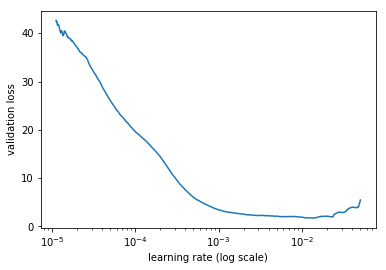

In [136]:
m1.sched.plot()

In [24]:
lr = 7e-4
wds = 1e-5

In [29]:
m1.fit(lr, 3, cycle_len=1, wds=wds)

epoch      trn_loss   val_loss                                  
    0      0.599184   1.437212  
    1      0.517373   1.321436                                  
    2      0.405765   1.261151                                  



[array([1.26115])]

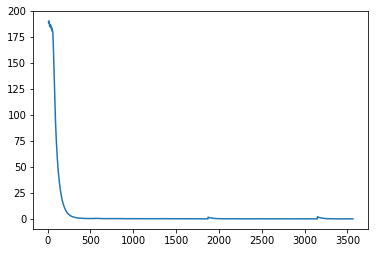

In [38]:
m1.sched.plot_loss()

In [33]:
m1.save('default_01') #0.36, 1.14

In [26]:
m1.load('default_01')

In [26]:
preds = m1.predict_dl(md.val_dl)

In [214]:
def show_preds(preds, val_idx, df, site_id, days):
    fig, axes = plt.subplots(days, 1, figsize=(12, 36))
    x = np.exp(preds) - 1
    dfa = df.reset_index()
    dfa = dfa[dfa['id'] == site_id]
    vals = []
    x_val = []
    for i in dfa.index.values:
        if i in val_idx:
            vals.append(i)
            x_val.append(list(val_idx).index(i))
    act = df.iloc[vals]['production'].values
    dates = df.reset_index().iloc[vals]['date'].dt.date.unique()
    x = x[x_val]
    for i, ax in enumerate(axes.flat):
        idx = 24*i
        ax.plot(act[idx:idx+24], label='Actual')
        ax.plot(x[idx:idx+24], label='Prediction')
        ax.set_xticks(np.arange(0, 23, step=1))
        ax.legend()
        ax.grid(color='b', linestyle='-', linewidth=0.1)
        ax.set_title(dates[i])
    plt.tight_layout()

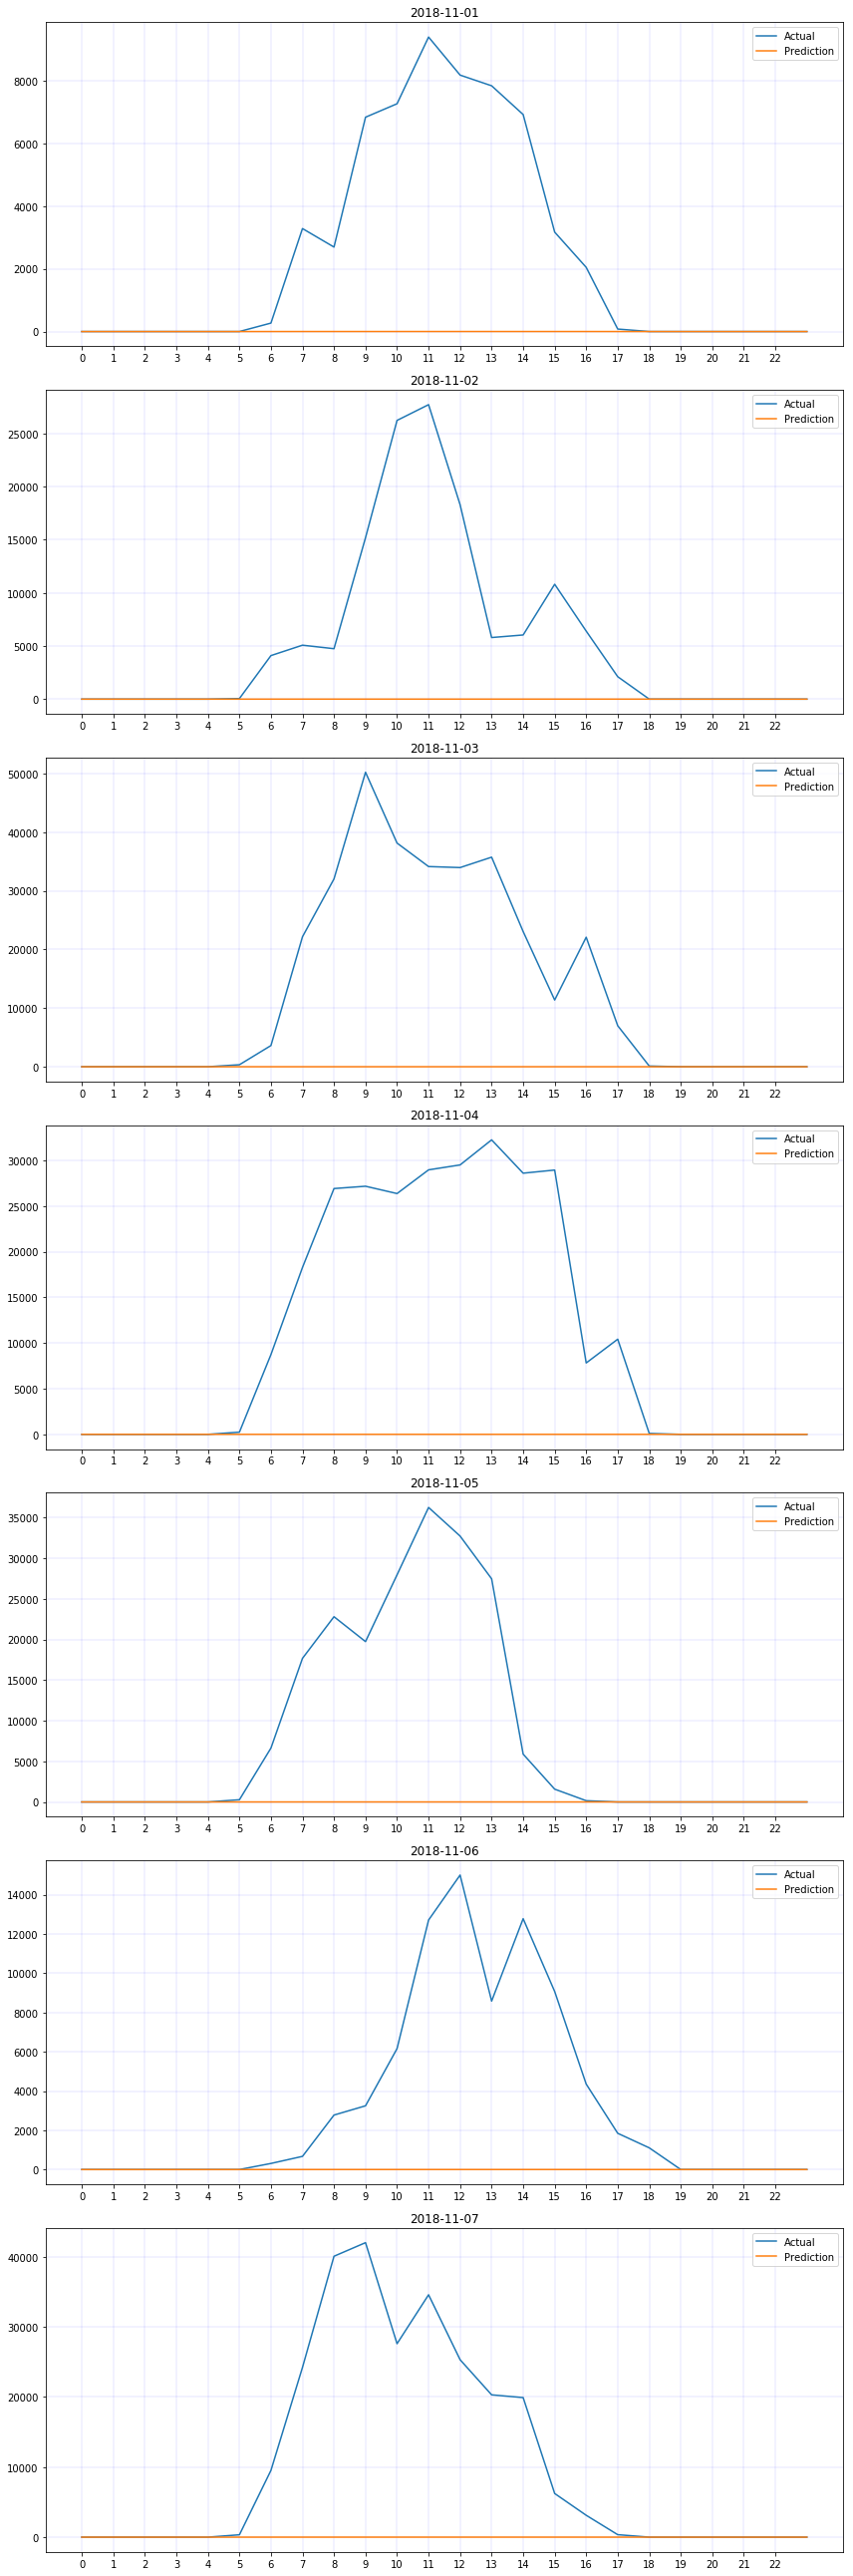

In [28]:
show_preds(preds,val_idx, pre_df, 658334, 7)

In [88]:
# Own Model 

In [240]:
def get_emb(n_in, n_out):
    layer = nn.Embedding(n_in, n_out)
    layer.weight.data.uniform_(-0.01, 0.01)
    return layer

In [241]:
class EmbeddingNet(nn.Module):
    def __init__(self, emb_sizes, input_size, nh, nl, p1, p2, y_range):
        super().__init__()
        self.emb = nn.ModuleList([get_emb(*o) for o in emb_sizes])
        self.lin1 = nn.Linear(input_size, nh)
        self.lin2 = nn.Linear(nh, nl)
        self.lin3 = nn.Linear(nl, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        self.max_y, self.min_y = y_range
        self.bn = nn.BatchNorm1d(input_size, eps=1e-6)
        
    def forward(self, cats, conts):
        for n in range(len(self.emb)):
            if n == 0:
                emb_out = self.emb[n](cats[:, n])
            else:
                emb_out = torch.cat([emb_out, self.emb[n](cats[:, n])], dim=1)
        x = self.drop1(torch.cat([emb_out, conts], dim=1))
        x = self.bn(x)
        x = self.drop2(F.relu(self.lin1(x)))
        x = self.drop2(F.relu(self.lin2(x)))
        return F.sigmoid(self.lin3(x))*(self.max_y - self.min_y) + self.min_y

In [256]:
cont_size = len(conts)
nh = 100
nl = 50
p1 = 0.008
p2 = 0.08
wds = 1e-5
lr = 1e-3

In [257]:
m2 = EmbeddingNet(emb_sizes, cont_size + 2 + emb_total, nh, nl, p1, p2, y_range).cuda()

In [258]:
learn = Learner.from_model_data(m2, md)

In [254]:
learn

EmbeddingNet(
  (emb): ModuleList(
    (0): Embedding(16, 8)
    (1): Embedding(892, 50)
    (2): Embedding(16, 8)
    (3): Embedding(31, 16)
    (4): Embedding(3, 2)
    (5): Embedding(3, 2)
    (6): Embedding(4, 2)
    (7): Embedding(13, 7)
    (8): Embedding(53, 27)
    (9): Embedding(32, 16)
    (10): Embedding(8, 4)
    (11): Embedding(367, 50)
    (12): Embedding(3, 2)
    (13): Embedding(3, 2)
    (14): Embedding(3, 2)
    (15): Embedding(3, 2)
    (16): Embedding(3, 2)
    (17): Embedding(3, 2)
    (18): Embedding(25, 13)
  )
  (lin1): Linear(in_features=228, out_features=100, bias=True)
  (lin2): Linear(in_features=100, out_features=50, bias=True)
  (lin3): Linear(in_features=50, out_features=1, bias=True)
  (drop1): Dropout(p=0.008)
  (drop2): Dropout(p=0.08)
  (bn): BatchNorm1d(228, eps=1e-06, momentum=0.1, affine=True)
)

In [249]:
learn.lr_find()

 64%|██████▍   | 854/1331 [00:05<00:03, 150.59it/s, loss=4.42]


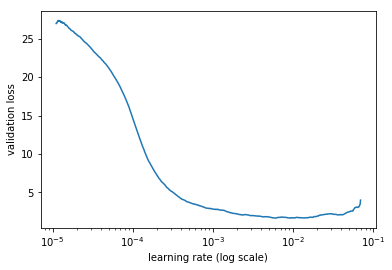

In [250]:
learn.sched.plot()

In [259]:
learn.fit(1e-3, 3, cycle_len=1, wds=wds)

epoch      trn_loss   val_loss                                  
    0      1.003997   1.372169  
    1      0.554256   0.788369                                  
    2      0.392571   0.663836                                  



[array([0.66384])]

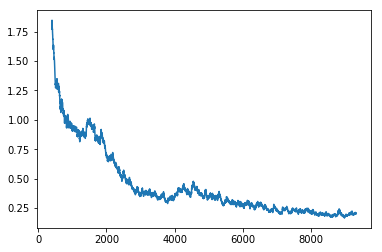

In [224]:
learn.sched.plot_loss(n_skip=400)

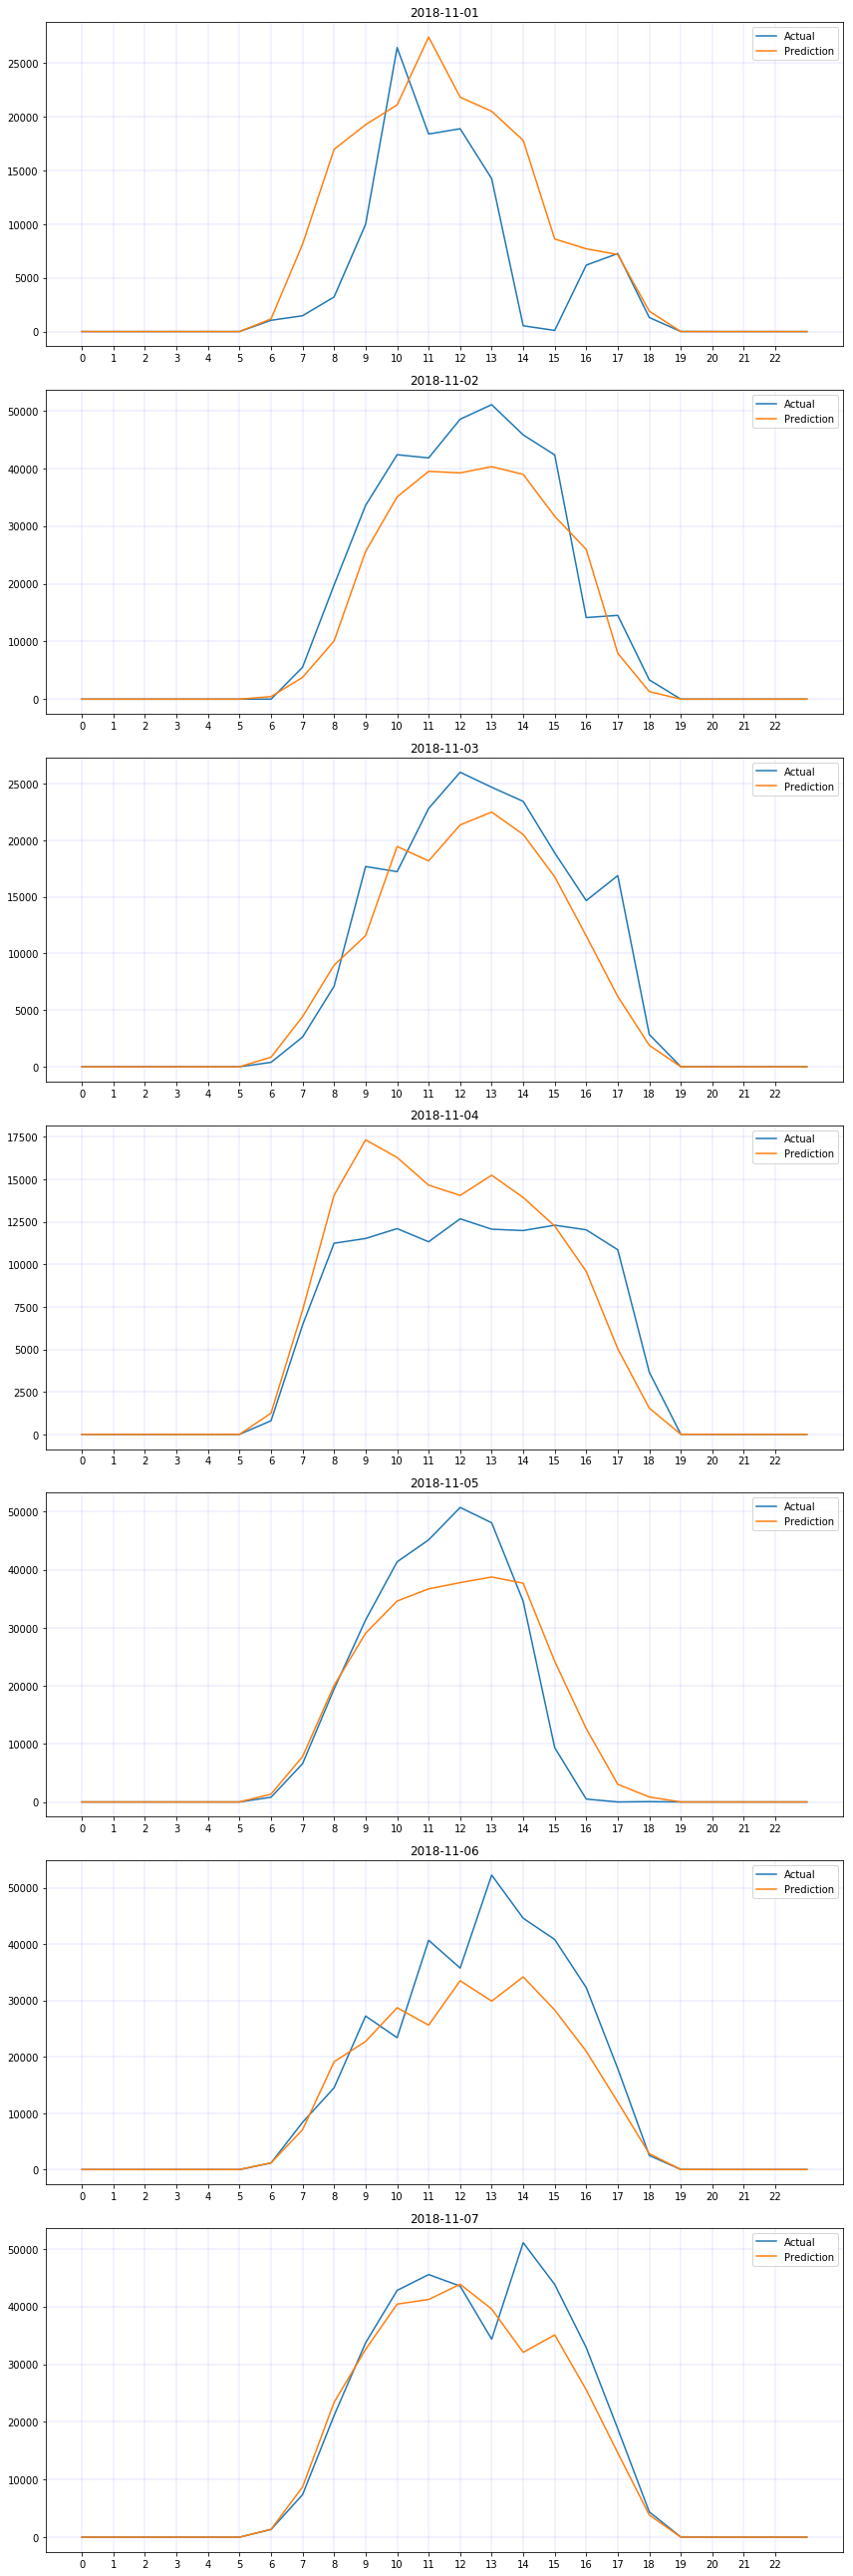

In [225]:
preds = learn.predict_dl(md.val_dl)
show_preds(preds,val_idx, pre_df, 322405, 7)

In [ ]:
seq model, more data, solarlog, pyronometer

In [ ]:
0.483, 0.663

In [37]:
pre_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 150122 entries, 2018-03-01 12:00:00 to 2018-11-17 23:00:00
Data columns (total 29 columns):
index                  150122 non-null int64
production             150122 non-null float64
install_date           150122 non-null category
id                     150122 non-null category
export_limitation      150122 non-null category
temperature            150122 non-null float32
uvIndex                150122 non-null category
windSpeed              150122 non-null float32
summary                150122 non-null category
apparentTemperature    150122 non-null float32
cloudCover             150122 non-null float32
dewPoint               150122 non-null float32
humidity               150122 non-null float32
precipType             150122 non-null category
windBearing            150121 non-null float32
Year                   150122 non-null category
Month                  150122 non-null category
Week                   150122 non-null category
Da